In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
from pprint import pp

# Data import en opschonen

In [3]:
data = pd.read_csv("../data/train.csv", delimiter=';')
data["overcrowding"] = data["overcrowding"].str.replace(",", ".").astype("float")
data["meaneduc"] = data["meaneduc"].str.replace(",", ".").astype("float")

In [4]:
X = data.drop(columns="target")
y = data["target"]

In [5]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, train_size=0.7)

# 1x Random Forest trainen

In [6]:
# clf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, n_jobs=-1, ccp_alpha=0.5, max_features=50)
params = {
    'n_estimators': 775,
    'min_samples_split': 2,
    'max_features': 50,
    'max_depth': 41,
    'criterion': 'entropy'
    }

clf = RandomForestClassifier(**params, n_jobs=-1)
clf = clf.fit(train_X, train_y)

In [7]:
clf.score(val_X, val_y)

0.9406631762652705

# Hyper parameter estimation

In [90]:
from sklearn.model_selection import RandomizedSearchCV

n_trees = [int(x) for x in np.linspace(start = 775, stop = 900, num = 10)]
max_depth = [int(x) for x in np.linspace(start = 15, stop = 50, num = 5)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 15, num = 5)]
max_features = [int(x) for x in np.linspace(start = 20, stop = 50, num = 5)]
criterion = ['gini', 'entropy']

param_grid = [
    {
        'n_estimators': n_trees,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'max_features':max_features, 
        'criterion': criterion
    },
]

grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit = True, n_jobs=-1, cv=5, n_iter=100, verbose=0, random_state=1) 

In [91]:
# fitting the model for grid search 
grid.fit(train_X, train_y) 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions=[{'criterion': ['gini', 'entropy'],
                                         'max_depth': [15, 23, 32, 41, 50],
                                         'max_features': [20, 27, 35, 42, 50],
                                         'min_samples_split': [2, 5, 8, 11, 15],
                                         'n_estimators': [775, 788, 802, 816,
                                                          830, 844, 858, 872,
                                                          886, 900]}])

In [108]:
# print best parameter after tuning 
pp(grid.best_params_) 
grid_predictions = grid.predict(val_X) 

# print classification report 
print("\n______________________________________________________")
print("Classification report: \n" + classification_report(val_y, grid_predictions)) 

{'n_estimators': 775,
 'min_samples_split': 2,
 'max_features': 50,
 'max_depth': 41,
 'criterion': 'entropy'}

______________________________________________________
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1467
           1       0.92      0.91      0.92       825

    accuracy                           0.94      2292
   macro avg       0.94      0.93      0.93      2292
weighted avg       0.94      0.94      0.94      2292



## Model overfitting analysis

In [8]:
# clf = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=10, n_jobs=-1, ccp_alpha=0.5, max_features=50)
train_score, val_score = [], []
depths = np.arange(1, 40)
for depth in depths:
    params = {
        'n_estimators': 775,
        'min_samples_split': 2,
        'max_features': 50,
        'max_depth': depth,
        'criterion': 'entropy'
        }
    clf = RandomForestClassifier(**params, n_jobs=-1)
    clf = clf.fit(train_X, train_y)
    train_score.append(clf.score(train_X, train_y))
    val_score.append(clf.score(val_X, val_y))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


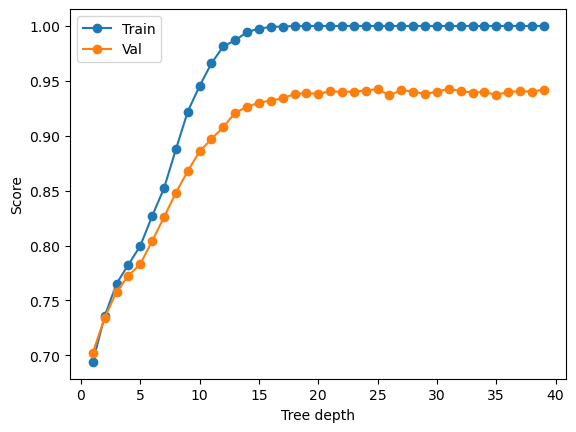

In [9]:
plt.plot(depths, train_score, '-o', label='Train')
plt.plot(depths, val_score, '-o', label='Val')
plt.legend()
plt.xlabel("Tree depth")
plt.ylabel("Score")
plt.savefig("../img/overfit_plot.eps")
plt.show()